In [1]:
'''This Notebook generates Figure 4a-c for the MIST manuscript.
'''

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
sys.path.append("MIST")
import utils
import neighbors
from sklearn import metrics
import sklearn
sklearn.__version__
from scipy.stats import pearsonr
import umap
from scipy.stats import ttest_ind as ttest

In [5]:
sys.path.append("holdout/")
import imputers

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler

In [7]:
"""READ the manual region annotation and coordinate information for spots"""

import warnings
warnings.filterwarnings('ignore')

spot_meta = pd.read_csv("data/spot_metadata.tsv", sep="\t")
spot_meta["anno"] = spot_meta["AT"]
spot_meta.loc[spot_meta.Level_01 == "CX", "anno"] = "CX"
spot_meta = spot_meta.dropna(subset=["anno"])
wt_meta = spot_meta.loc[spot_meta.Group == "WT_12",:]
wt_meta['count_id'] = wt_meta[["coord_X", "coord_Y"]].astype(str).apply(lambda x: "x".join(x), axis=1)
ad_meta = spot_meta.loc[spot_meta.Group == "AD_12",:]
ad_meta['count_id'] = ad_meta[["coord_X", "coord_Y"]].astype(str).apply(lambda x: "x".join(x), axis=1)

## Fig. 4a -- Mouse WT Brain UMAP

Text(0.5, 0, 'UMAP 1')

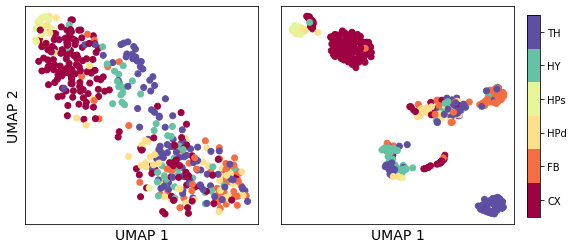

In [9]:
"""UMAP results for Mouse WT brain with or without imputation"""
f, axs = plt.subplots(ncols=2,nrows=1, figsize=(9,4))
################ RAW ##################
## UMAP with raw data
wt_raw, wt_raw_meta = utils.read_ST_data("data/MouseWT/raw.csv")
wt_raw, _= utils.data_norm(wt_raw, method="logCPM") # log2 normalize
wt_raw = wt_raw.loc[wt_meta.count_id,:]
fit1 = umap.UMAP(random_state=1, n_neighbors=10)
u1 = fit1.fit_transform(wt_raw)
uniques1, c1 = np.unique(wt_meta.anno.tolist(), return_inverse=True) # colorbar preprocess
p1 = axs[0].scatter(u1[:,0], u1[:,1], c=c1, alpha=1.0, cmap="Spectral")
plt.setp(axs[0], xticks=[], yticks=[])

################ IMPUTED ##################
## UMAP with imputed data
wt_imp, wt_imp_meta = utils.read_ST_data("data/MouseWT/imputed.csv") 
wt_imp = np.log2(wt_imp + 1) # log2
wt_imp = wt_imp.loc[wt_meta.count_id,:]
fit2 = umap.UMAP(random_state=1, n_neighbors=10)
u2 = fit2.fit_transform(wt_imp)
uniques2, c2 = np.unique(wt_meta.anno.tolist(), return_inverse=True)
p2 = axs[1].scatter(u2[:,0], u2[:,1], c=c2, alpha=1.0, cmap="Spectral")
plt.setp(axs[1], xticks=[], yticks=[])

## Adjust layout
f.subplots_adjust(right=0.88, wspace=0.1, hspace=0)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = f.colorbar(p2, cax=cbar_ax, boundaries=np.arange(-0.5, len(uniques2)+0.5, 1))
cbar.set_ticks(np.arange(len(uniques2)))
cbar.set_ticklabels(uniques2)
axs[0].set_xlabel("UMAP 1", fontsize=14)
axs[0].set_ylabel("UMAP 2", fontsize=14)
axs[1].set_xlabel("UMAP 1", fontsize=14)
#plt.savefig("Figures/Figure4A.png", dpi=300, bbox_inches="tight")

## Extended 4.1

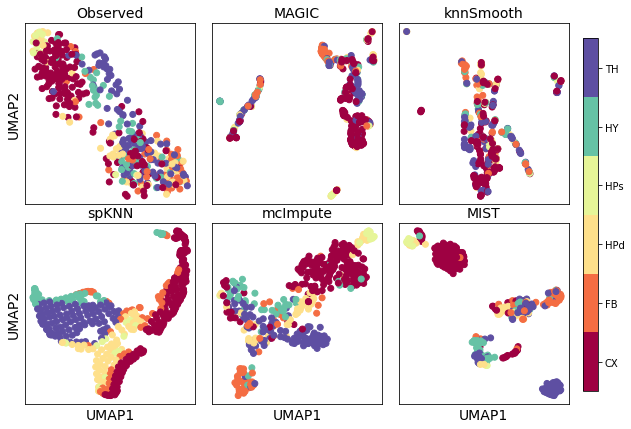

In [11]:
"""This block makes UMAP with gene expression data imputed by different imputation methods,
Data imputed by other methods are not included, but can be achieved by
running the run_other_imputers.py.
"""
f = plt.figure(figsize=(10,7))
################ RAW ##################
wt_raw, wt_raw_meta = utils.read_ST_data("data/MouseWT/raw.csv")
wt_raw, _= utils.data_norm(wt_raw, method="logCPM")
wt_raw = wt_raw.loc[wt_meta.count_id,:]
fit1 = umap.UMAP(random_state=1, n_neighbors=10)
u1 = fit1.fit_transform(wt_raw)
uniques1, c1 = np.unique(wt_meta.anno.tolist(), return_inverse=True)
k =1
f.add_subplot(2,3,k)
p1 = plt.scatter(u1[:,0], u1[:,1], c=c1, alpha=1.0, cmap="Spectral")
plt.title("Observed", fontsize=14)
plt.ylabel("UMAP2", fontsize=14)
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False,
    labelbottom=False) 

################ IMPUTED ##################
for method in ['MAGIC', 'knnSmooth','spKNN','mcImpute', 'MIST']:
    k += 1
    # Generate and plot UMAP results
    wt_imp, wt_imp_meta = utils.read_ST_data("data/MouseWT/MouseWT_%s.csv" %method)
    wt_imp = np.log2(wt_imp + 1)
    wt_imp = wt_imp.loc[wt_meta.count_id,:]
    fit2 = umap.UMAP(random_state=1, n_neighbors=10)
    u2 = fit2.fit_transform(wt_imp)
    uniques2, c2 = np.unique(wt_meta.anno.tolist(), return_inverse=True)
    # Adjust figure layout
    f.add_subplot(2,3,k)
    plt.scatter(u2[:,0], u2[:,1], c=c2, alpha=1.0, cmap="Spectral")
    plt.title(method, fontsize=14)
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False,
    labelbottom=False) 
    # Label figure axis
    if k > 3:
        plt.xlabel("UMAP1", fontsize=14)
    if k == 4:
        plt.ylabel("UMAP2", fontsize=14)
        
f.subplots_adjust(right=0.88, wspace=0.1, hspace=0.1)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = f.colorbar(p1, cax=cbar_ax, boundaries=np.arange(-0.5, len(uniques2)+0.5, 1))
cbar.set_ticks(np.arange(len(uniques2)))
cbar.set_ticklabels(uniques2)

#plt.savefig("Figures/Ext-4.1.png", dpi=300, bbox_inches="tight")

## Fig. 4b -- Mouse AD Brain UMAP

Text(0.5, 0, 'UMAP 1')

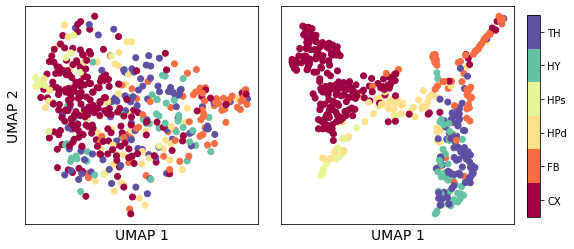

In [12]:
"""UMAP results for Mouse AD brain with or without imputation"""

f, axs = plt.subplots(ncols=2,nrows=1, figsize=(9,4))
################ RAW ##################
# Read and process raw AD data
ad_raw, ad_raw_meta = utils.read_ST_data("data/MouseAD/raw.csv")
ad_raw, _= utils.data_norm(ad_raw, method="logCPM")
ad_raw = ad_raw.loc[ad_meta.count_id,:]

# Get UMAP results and figure for raw data
fit1 = umap.UMAP(random_state=1, n_neighbors=10)
u1 = fit1.fit_transform(ad_raw)
uniques1, c1 = np.unique(ad_meta.anno.tolist(), return_inverse=True)
p1 = axs[0].scatter(u1[:,0], u1[:,1], c=c1, alpha=1.0, cmap="Spectral")
plt.setp(axs[0], xticks=[], yticks=[])

################ IMPUTED ##################
# Read and process imputed AD data
ad_imp, ad_imp_meta = utils.read_ST_data("data/MouseAD/imputed.csv")
ad_imp = np.log2(ad_imp + 1)
ad_imp = ad_imp.loc[ad_meta.count_id,:]

# Get UMAP results and figure for imputed data
fit2 = umap.UMAP(random_state=1, n_neighbors=10)
u2 = fit2.fit_transform(ad_imp)
uniques2, c2 = np.unique(ad_meta.anno.tolist(), return_inverse=True)
p2 = axs[1].scatter(u2[:,0], u2[:,1], c=c2, alpha=1.0, cmap="Spectral")
plt.setp(axs[1], xticks=[], yticks=[])

f.subplots_adjust(right=0.88, wspace=0.1, hspace=0)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = f.colorbar(p2, cax=cbar_ax, boundaries=np.arange(-0.5, len(uniques2)+0.5, 1))
cbar.set_ticks(np.arange(len(uniques2)))
cbar.set_ticklabels(uniques2)
axs[0].set_xlabel("UMAP 1", fontsize=14)
axs[0].set_ylabel("UMAP 2", fontsize=14)
axs[1].set_xlabel("UMAP 1", fontsize=14)

#cbar_ax.axis("off")
#plt.savefig("Figures/Figure4B.png", dpi=300, bbox_inches="tight")

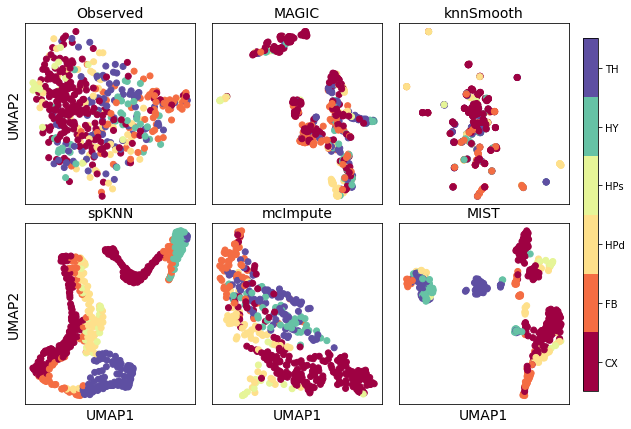

In [13]:
"""This block makes UMAP with gene expression data imputed by different
imputation methods for Mouse AD brain.

Data imputed by other methods are not included, but can be achieved by
running the run_other_imputers.py.
"""

f = plt.figure(figsize=(10,7))

################ RAW ##################
ad_raw, ad_raw_meta = utils.read_ST_data("data/MouseAD/raw.csv")
ad_raw, _= utils.data_norm(ad_raw, method="logCPM")
ad_raw = ad_raw.loc[ad_meta.count_id,:]

fit1 = umap.UMAP(random_state=1, n_neighbors=10)
u1 = fit1.fit_transform(ad_raw)
uniques1, c1 = np.unique(ad_meta.anno.tolist(), return_inverse=True)
k =1
f.add_subplot(2,3,k)
p1 = plt.scatter(u1[:,0], u1[:,1], c=c1, alpha=1.0, cmap="Spectral")
plt.title("Observed", fontsize=14)
plt.ylabel("UMAP2", fontsize=14)
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False,
    labelbottom=False) 

################ IMPUTED ##################
for method in ['MAGIC', 'knnSmooth','spKNN','mcImpute', 'MIST']:
    k += 1
    ad_imp, ad_imp_meta = utils.read_ST_data("data/MouseAD/MouseAD_%s.csv" %method)
    ad_imp = np.log2(ad_imp + 1)
    ad_imp = ad_imp.loc[ad_meta.count_id,:]

    fit2 = umap.UMAP(random_state=1, n_neighbors=10)
    u2 = fit2.fit_transform(ad_imp)

    uniques2, c2 = np.unique(ad_meta.anno.tolist(), return_inverse=True)
    f.add_subplot(2,3,k)
    plt.scatter(u2[:,0], u2[:,1], c=c2, alpha=1.0, cmap="Spectral")
    plt.title(method, fontsize=14)
    if method == 'spImpute':
        plt.title('MIST', fontsize=14)
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False,
    labelbottom=False) 
    
    if k > 3:
        plt.xlabel("UMAP1", fontsize=14)
    if k == 4:
        plt.ylabel("UMAP2", fontsize=14)
        
f.subplots_adjust(right=0.88, wspace=0.1, hspace=0.1)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = f.colorbar(p1, cax=cbar_ax, boundaries=np.arange(-0.5, len(uniques2)+0.5, 1))
cbar.set_ticks(np.arange(len(uniques2)))
cbar.set_ticklabels(uniques2)
#plt.savefig("Figures/Ext-4.2.png", dpi=300, bbox_inches="tight")

## Fig. 4c  -- AD Cortex UMAP

Text(0.5, 0, 'UMAP 1')

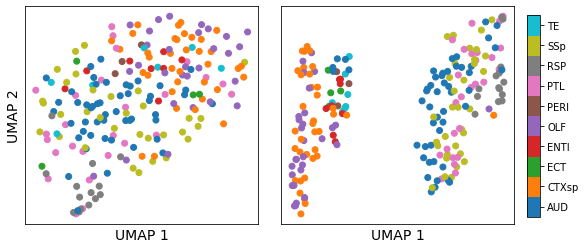

In [10]:
"""This block makes UMAP with gene expression data imputed
by different imputation methods for Mouse AD cortex region"""

f, axs = plt.subplots(ncols=2,nrows=1, figsize=(9,4))

################ RAW ##################
cx_meta = ad_meta.loc[ad_meta.Level_01 == "CX",:]
cx_spots = cx_meta.count_id.tolist()
cx_raw = ad_raw.loc[cx_spots,:]
fit1 = umap.UMAP(random_state=1, n_neighbors=10)
u1 = fit1.fit_transform(cx_raw)
uniques, c = np.unique(cx_meta.AT.tolist(), return_inverse=True)
p1 = axs[0].scatter(u1[:,0], u1[:,1], c=c, alpha=1.0, cmap="tab10")
plt.setp(axs[0], xticks=[], yticks=[])

################ IMPUTED ##################
cx_im = ad_imp.loc[cx_spots,:]
fit2 = umap.UMAP(random_state=1, n_neighbors=10)
u2 = fit2.fit_transform(cx_im)
p2 = axs[1].scatter(u2[:,0], u2[:,1], c=c, alpha=1.0, cmap="tab10")
plt.setp(axs[1], xticks=[], yticks=[])

# Adjust layout
f.subplots_adjust(right=0.88, wspace=0.1, hspace=0)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = f.colorbar(p2, cax=cbar_ax, boundaries=np.arange(-0.5, len(uniques)+0.5, 1))
cbar.set_ticks(np.arange(len(uniques)))
cbar.set_ticklabels(uniques)
axs[0].set_xlabel("UMAP 1", fontsize=14)
axs[0].set_ylabel("UMAP 2", fontsize=14)
axs[1].set_xlabel("UMAP 1", fontsize=14)

#plt.savefig("Figures/Figure4C.png", dpi=300, bbox_inches="tight")

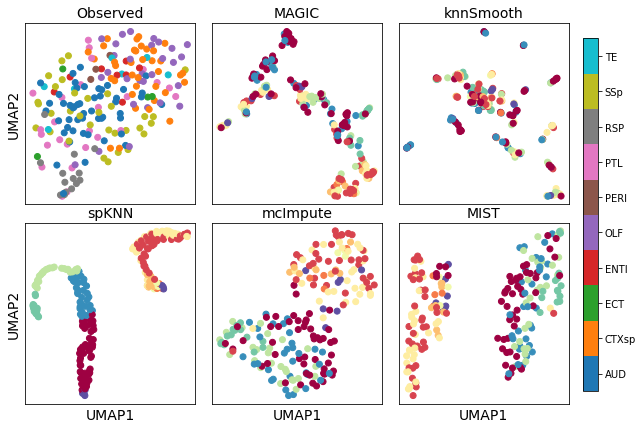

In [18]:
"""This block makes UMAP with gene expression data imputed
by different imputation methods for Mouse AD cortex region"""

f = plt.figure(figsize=(10,7))

################ RAW ##################
cx_meta = ad_meta.loc[ad_meta.Level_01 == "CX",:]
cx_spots = cx_meta.count_id.tolist()
cx_raw = ad_raw.loc[cx_spots,:]
cx_im = ad_imp.loc[cx_spots,:]

fit1 = umap.UMAP(random_state=1, n_neighbors=10)
u1 = fit1.fit_transform(cx_raw)
uniques, c = np.unique(cx_meta.AT.tolist(), return_inverse=True)
k =1
f.add_subplot(2,3,k)
p1 = plt.scatter(u1[:,0], u1[:,1], c=c, alpha=1.0, cmap="tab10")
plt.title("Observed", fontsize=14)
plt.ylabel("UMAP2", fontsize=14)
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False,
    labelbottom=False) 

################ IMPUTED ##################
for method in ['MAGIC', 'knnSmooth','spKNN','mcImpute', 'MIST']:
    k += 1
    ad_imp, ad_imp_meta = utils.read_ST_data("../MIST_Imputed/MouseAD/MouseAD_%s.csv" %method)
    ad_imp = np.log2(ad_imp + 1)
    cx_imp = ad_imp.loc[cx_meta.count_id,:]

    fit2 = umap.UMAP(random_state=1, n_neighbors=10)
    u2 = fit2.fit_transform(cx_imp)

    uniques2, c2 = np.unique(cx_meta.AT.tolist(), return_inverse=True)
    f.add_subplot(2,3,k)
    plt.scatter(u2[:,0], u2[:,1], c=c2, alpha=1.0, cmap="Spectral")
    plt.title(method, fontsize=14)

    # Adjust layout
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False,
    labelbottom=False) 
    
    if k > 3:
        plt.xlabel("UMAP1", fontsize=14)
    if k == 4:
        plt.ylabel("UMAP2", fontsize=14)
# Adjust layout       
f.subplots_adjust(right=0.88, wspace=0.1, hspace=0.1)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = f.colorbar(p1, cax=cbar_ax, boundaries=np.arange(-0.5, len(uniques2)+0.5, 1))
cbar.set_ticks(np.arange(len(uniques2)))
cbar.set_ticklabels(uniques2)
#plt.savefig("Figures/Ext-4.3.png", dpi=300, bbox_inches="tight")

In [93]:
mouse_raw, _ = utils.read_ST_data("raw/MouseWT_raw.csv")
raw_filtered = utils.filterGene_sparsity(mouse_raw, 0.2)
print(mouse_raw.shape, raw_filtered.shape)

(447, 11238) (447, 8003)


In [192]:
deg01 = pd.read_csv("AD_CX_up_DEGs_0v1.csv", index_col=0)
print(deg01.shape)
deg01_raw = pd.read_csv("AD_CX_up_DEGs_raw_0v1.csv", index_col=0)
deg01 = deg01.loc[~deg01.index.isin(deg01_raw.index),:]
deg01['abslogFC'] = np.absolute(deg01['logFC'].to_numpy())
deg01 = deg01.sort_values("abslogFC", ascending=False)
deg01

(1462, 6)


,logFC,AveExpr,t,P.Value,adj.P.Val,B,abslogFC
Gm7815,-1.355723,6.179542,-9.298803,2.030000e-17,2.150000e-16,28.765580,1.355723
Npy,-1.224533,6.783875,-7.760019,3.790000e-13,2.320000e-12,19.061995,1.224533
Chd1l,-1.186626,6.208220,-6.339373,1.410000e-09,5.370000e-09,10.991507,1.186626
Arc,-1.113545,6.441450,-9.223302,3.340000e-17,3.450000e-16,28.270990,1.113545
F2r,-1.096736,5.940797,-18.181923,7.990000e-45,4.470000e-42,91.351816,1.096736
...,...,...,...,...,...,...,...
Tapt1,-0.580288,6.052245,-7.338312,4.800000e-12,2.560000e-11,16.564269,0.580288
Zfp131,-0.580204,6.066286,-6.287676,1.870000e-09,6.970000e-09,10.717592,0.580204
RP24.151D9.9,-0.580152,5.697085,-9.670816,1.680000e-18,2.040000e-17,31.225881,0.580152
Cyp4f13,-0.580150,5.774088,-11.693714,1.340000e-24,3.500000e-23,45.133845,0.580150


In [194]:
deg02 = pd.read_csv("AD_CX_up_DEGs_0v2.csv", index_col=0)
print(deg01.shape)
deg02_raw = pd.read_csv("AD_CX_up_DEGs_raw_0v2.csv", index_col=0)
deg02 = deg02.loc[~deg02.index.isin(deg02_raw.index),:]
deg02['abslogFC'] = np.absolute(deg02['logFC'].to_numpy())
deg02 = deg02.sort_values("abslogFC", ascending=False)
deg02

(1415, 7)


,logFC,AveExpr,t,P.Value,adj.P.Val,B,abslogFC
Cdk5rap2,-1.584605,6.111018,-13.122086,4.815320e-29,1.481192e-25,55.127852,1.584605
Lypd1,1.462707,6.642961,7.482992,2.025390e-12,2.059537e-10,17.772837,1.462707
Crym,1.158284,6.843641,5.766188,2.908713e-08,9.996872e-07,8.505075,1.158284
Chd1l,-0.986533,6.208220,-3.804137,1.871428e-04,1.855443e-03,0.158709,0.986533
Pdlim4,-0.946173,5.755606,-12.706740,9.594179e-28,1.967446e-24,52.206945,0.946173
...,...,...,...,...,...,...,...
Slc35f4,-0.580829,5.813141,-7.022760,3.048050e-11,2.435273e-09,15.139685,0.580829
Ppp1r14a,-0.580721,6.168846,-4.016359,8.258962e-05,9.339914e-04,0.924719,0.580721
Dcaf17,0.580701,5.528676,8.500750,3.681590e-15,6.760938e-13,23.915475,0.580701
Ipo8,-0.580574,6.044821,-4.105345,5.802576e-05,6.931543e-04,1.256485,0.580574


In [199]:
deg0 = [g for g in deg01.loc[deg01.logFC > 0,:].index.tolist() if g in deg02.loc[deg02.logFC > 0,:].index.tolist()]
deg0

[]

In [193]:
deg12 = pd.read_csv("AD_CX_up_DEGs_1v2.csv", index_col=0)
print(deg01.shape)
deg12_raw = pd.read_csv("AD_CX_up_DEGs_raw_1v2.csv", index_col=0)
deg12 = deg12.loc[~deg12.index.isin(deg12_raw.index),:]
deg12['abslogFC'] = np.absolute(deg12['logFC'].to_numpy())
deg12 = deg12.sort_values("abslogFC", ascending=False)
deg12

(1415, 7)


,logFC,AveExpr,t,P.Value,adj.P.Val,B,abslogFC
Lamp5,1.420232,7.219605,7.830638,2.456553e-13,8.863764e-12,19.769765,1.420232
Scn1b,1.046004,8.654491,6.532745,4.890785e-10,7.646105e-09,12.361997,1.046004
Zfp800,0.988292,5.841183,10.955940,2.441459e-22,6.827207e-20,40.098982,0.988292
Gm7815,0.963934,6.179542,5.256037,3.643164e-07,2.819213e-06,5.962267,0.963934
Cdk5rap2,-0.962347,6.111018,-8.777208,6.211633e-16,4.109029e-14,25.623457,0.962347
...,...,...,...,...,...,...,...
Sorcs1,0.581360,5.704237,9.677261,1.611456e-18,1.885779e-16,31.462958,0.581360
Trak2,0.580960,6.545022,3.579916,4.279386e-04,1.408603e-03,-0.752391,0.580960
Pced1a,0.580730,5.867526,7.439554,2.626732e-12,7.214132e-11,17.454795,0.580730
Stk40,0.580715,5.913926,5.874427,1.667070e-08,1.745670e-07,8.938808,0.580715
